In [169]:
%matplotlib notebook
from __future__ import division

In [26]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
inf = float("inf")

In [172]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose
from schlichtanders.myoptimizers import batch
from schlichtanders.mygenerators import eatN, chunk, every
from schlichtanders.myplot import add_val, add_point

In [24]:
from theano_models import as_tensor_variable
import theano_models.deterministic_models as dm
import theano_models.postmaps as post
from theano_models import reparameterize_map

# Data

In [131]:
datafile = '../data/mnist.pkl.gz'
# Load data.                                                                                                   

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]
map(np.shape, [X, Z, VX, VZ, TX, TZ])

[(50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10)]

# Model

In [30]:
mlp = dm.Mlp(output_size=10, output_transfer="softmax", hidden_sizes=[200]*2, hidden_transfers=["rectifier"]*2)
mlp

[array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1]),
 array([10])]

# Optimizer

In [31]:
postmap = compose(post.flat_numericalize_postmap, post.flatten_parameters, post.deterministic_optimizer_postmap)
postmap_kwargs = {
    'wrapper': batch,
    'initial_inputs': [X[0]],
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size) * 0.01
}
optimizer_kwargs = postmap(mlp, **postmap_kwargs)
post.climin_postmap(optimizer_kwargs)

{'f': <function schlichtanders.myoptimizers.f_batch>,
 'fprime': <function schlichtanders.myoptimizers.f_batch>,
 'wrt': array([ 0.00645698,  0.0022943 , -0.01834677, ...,  0.01278242,
         0.00088766, -0.00680738])}

Climin wants an iterators of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [32]:
batch_size = 30
climin_args = izip(izip(chunk(batch_size, cycle(Z)), chunk(batch_size, cycle(X))), repeat({}))

In [33]:
opt = optimizer(
    identifier = "adadelta",
    args=climin_args, # repeat(((Z,X),{})),
    **post.climin_postmap(optimizer_kwargs)
)

# Visualized Fit

<IPython.core.display.Javascript object>


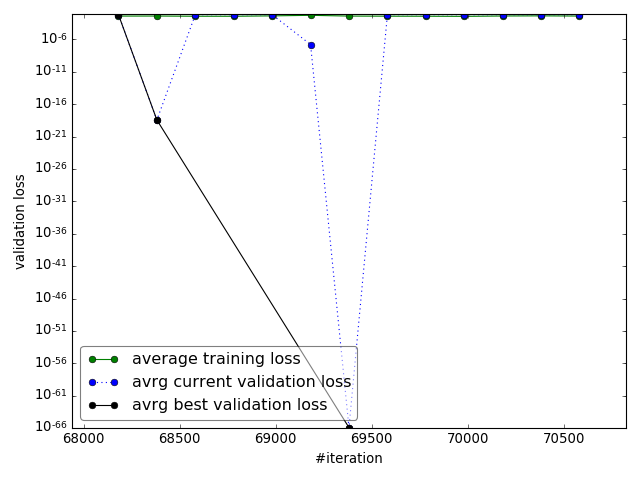

In [178]:
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
ylabel("validation loss")
xlabel("#iteration")
legend(loc='lower left', fancybox=True, framealpha=0.5)

In [179]:
best_val_loss = inf
best_wrt = None
val_size = batch_size

n_whole_data = X.shape[0] // batch_size

for info in every(n_whole_data, opt):
    # collect and visualize validation loss for choosing the best model
    val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ[:val_size], VX[:val_size])/val_size
    if val_loss < best_val_loss:
        best_wrt = opt.wrt
        best_val_loss = val_loss
        add_point(line_best_val, info['n_iter'], val_loss)
    add_point(line_curr_val, info['n_iter'], val_loss)
    
    # visualize training loss for comparison:
    try:
        training_loss = info['loss'] / len(Z)  # TODO normalization needed?
    except KeyError:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z, X)/len(Z)
    add_point(line_train, info['n_iter'], training_loss)

KeyboardInterrupt: 

# Performance

In [185]:
print best_val_loss
mlp['parameters_flat'] = best_wrt

predict = mlp.function()
predict(X[0]), Z[0]

1.17342346945e-66
fancy reshaping


(array([  5.88143951e-316,   2.32742273e-230,   0.00000000e+000,
          1.61705969e-111,   0.00000000e+000,   1.00000000e+000,
          3.38022210e-253,   7.10047993e-288,   1.96972291e-185,
          1.02151700e-234]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))

In [182]:
PX = np.apply_along_axis(predict, 1, X)
PVX = np.apply_along_axis(predict, 1, VX)
PTX = np.apply_along_axis(predict, 1, TX)

In [183]:
print 'incorrect samples train/val/test:  %i/%i/%i' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).sum(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).sum(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).sum())

print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())

incorrect samples train/val/test:  1088/314/330
error rate train/val/test:  0.02176/0.0314/0.033
